# Assignment Task 1 - AI for Search and Optimsation
Student Id: 23017940

<b>Note:</b> Reusable functions are written first, make sure to run them before running the simulated annealing functions.

In [2]:
# Check PEP8 standard compatibility (install flake8 in conda navigator before running this cell)
!flake8 Assignment_Task1_Solution.ipynb

# most of the flake8 issues are because of the line length, which I tried to keep to a minimum

zsh:1: command not found: flake8


In [3]:
# Import required modules
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

random.seed(42)

In [4]:
# Read CSV file and output items as a list
def read_csv_file(filename):
    items_list = []
    try:
        # check the file format is csv
        if filename.endswith((".csv")): 
            items = pd.read_csv(filename, header=None)
            items_list = items.iloc[:, 0].values.tolist()
        else:
            print("Invalid File format. Please enter a csv file")
    except FileNotFoundError:
        print("File not found")
    except Exception as e:
        print(f"Oops, an error occured! {e}")
    return items_list

In [5]:
# Write the best solution to a file
def write_to_file_function(file_path, best_evaluation, best_solution):
    try:
        with open(file_path, "w") as file:
            file.write(f"Minimum bins required: {best_evaluation} bins \n")
            file.write("\n")
            for bin_index, bin_items in enumerate(best_solution):
                file.write(f"Bin {bin_index + 1}:"
                           f"{bin_items} | Total Weight: {round(sum(bin_items), 2)} \n")
        print(f"Results written to {file_path}")
    except Exception as e:
        print(f"Oops, an error occured! {e}")

In [6]:
# Swap (1, 0)
def swap_one_to_zero_function(solution, bin_capacity):
    if len(solution) < 2: 
        return solution  # cannot swap without at least two bins
    
    # select a random bin as the first bin
    first_bin = random.randint(0, len(solution) - 1) 
    # select a second bin that is not the first bin
    second_bin = random.choice([i for i in range(len(solution)) if i != first_bin])  
    
    if solution[first_bin]:
        # select a random item from the bin
        move_item = random.choice(solution[first_bin])  
        # check if moving the item doesn't exceed the bin capacity
        if sum(solution[second_bin]) + move_item <= bin_capacity:  
            solution[first_bin].remove(move_item)
            solution[second_bin].append(move_item)

    res = list(filter(None, solution))  # Remove any empty bins

    return res

In [7]:
# Swap (0, 1)
def swap_zero_to_one_function(solution, bin_capacity):
    if len(solution) < 2: 
        return solution  # cannot swap without at least two bins
    
    # select a random bin as the first bin
    first_bin = random.randint(0, len(solution) - 1)  
    # select a second bin that is not the first bin
    second_bin = random.choice([i for i in range(len(solution)) if i != first_bin])  
    
    if solution[second_bin]:
        # select a random item from the bin
        move_item = random.choice(solution[second_bin])  
        # check if moving the item doesn't exceed the bin capacity
        if sum(solution[first_bin]) + move_item <= bin_capacity: 
            solution[second_bin].remove(move_item)
            solution[first_bin].append(move_item)

    res = list(filter(None, solution))  # Remove any empty bins

    return res

In [8]:
# Swap (1, 1)
def swap_one_to_one_function(solution, bin_capacity):
    if len(solution) < 2:
        return solution

    first_bin, second_bin = random.sample(range(len(solution)), 2) # select two random bins

    if solution[first_bin] and solution[second_bin]:
        # select two items from bin
        item1 = random.choice(solution[first_bin])
        item2 = random.choice(solution[second_bin])
        first_bin_sum = sum(solution[first_bin])
        second_bin_sum = sum(solution[second_bin])

        # check if adding items doesn't exceed bin capacity
        if first_bin_sum - item1 + item2 <= bin_capacity and second_bin_sum - item2 + item1 <= bin_capacity:
            # remove form each bin
            solution[first_bin].remove(item1)             
            solution[second_bin].remove(item2)
            # add to the other bin
            solution[first_bin].append(item2)
            solution[second_bin].append(item1)

    return solution

In [9]:
# Objective Function
def objective_function(solution):
    no_of_bins = len(solution)
    score = 0 # current score

    for i in range(no_of_bins):
        total_of_bin_weights = sum(solution[i]) # sum of items inside each bin
        score += total_of_bin_weights ** 2 # squared the sum and assign to score

    return score

### Simulated Annealing with Best Fit

In [10]:
# Initial variables
bin_capacity = 100
temperature = 1000 # initial temperature
cooling_rate = 0.95
stopping_temperature = 0.01
max_iterations = 100000
items = read_csv_file("items.csv")

# Plot values
bf_sa_objective_function_results = [] 
bf_sa_no_of_bins = []
bf_sa_temperatures = [] 


# Best Fit
def best_fit_function(solution, bin_capacity):
    bins = []

    for item in solution:
        best_bin_index = -1 # initial index
        best_space_left = float('inf') # initial empty space left

        for bin_index, bin_items in enumerate(bins):
            bin_weight = sum(bin_items) # calculate current bin total weight
            space_left = bin_capacity - bin_weight # calculate how much space left

            # check if item fit space
            if space_left >= item and space_left < best_space_left:
                best_bin_index = bin_index # assign current bin as best
                best_space_left = space_left # assign current space in bin as best

        if best_bin_index != -1:
            bins[best_bin_index].append(item) # add item to bin if there's space
        else:
            bins.append([item]) # otherwise open a new bin

    return bins

# Simulated annealing with Best Fit initial solution
def simulated_annealing_best_fit(items, bin_capacity, temperature, cooling_rate, 
                                 stopping_temperature, max_iterations):
    current_solution = best_fit_function(items, bin_capacity) # calculate the initial solution
    current_evaluation = objective_function(current_solution) # calculate the initial energy

    # assign current solution and evaluation as the best solution and evaluation
    best_solution = current_solution
    best_evaluation = current_evaluation

    for i in range(max_iterations):
        while temperature > stopping_temperature: 
            swapping = [swap_one_to_zero_function, swap_zero_to_one_function, swap_one_to_one_function]

            # try different swapping methods
            for swap in swapping:
                new_candidate = swap(current_solution, bin_capacity) # generate neighbour/new candidates
                new_evaluation = objective_function(new_candidate) # calculate new candidates energy
    
                # compare new and best evaluation
                if new_evaluation > best_evaluation:
                    best_solution, best_evaluation = new_candidate, new_evaluation
    
                energy_variance = new_evaluation - current_evaluation # energy difference
                metropolis = np.exp(-energy_variance / temperature) # calculate metropolis
                
                # acceptance criteria
                if energy_variance < 0 or random.uniform(0, 1) < metropolis:
                    current_solution, current_evaluation = new_candidate, new_evaluation
                
                # add values to the plot
                bf_sa_objective_function_results.append(best_evaluation)
                bf_sa_temperatures.append(temperature)
                bf_sa_no_of_bins.append(len(current_solution))
                
            # temperature cool down
            temperature *= cooling_rate

    return best_solution, len(best_solution)

In [11]:
# Call the SA function
best_fit_solution, bf_minimum_bins = simulated_annealing_best_fit(items, 
                                                                      bin_capacity, 
                                                                      temperature, 
                                                                      cooling_rate, 
                                                                      stopping_temperature, 
                                                                      max_iterations)

# Write items to the file
bsf_path = "best_fit_simulated_annealing.txt"
write_to_file_function(bsf_path, bf_minimum_bins, best_fit_solution)

# Print minimum number to console
print("Number of Bins Used:", bf_minimum_bins)

Results written to best_fit_simulated_annealing.txt
Number of Bins Used: 89


/var/folders/pk/d3blxj6x2zd9tww6j6dlvhyc0000gn/T/ipykernel_71910/2062851120.py:63: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-energy_variance / temperature) # calculate metropolis


#### Visualisations

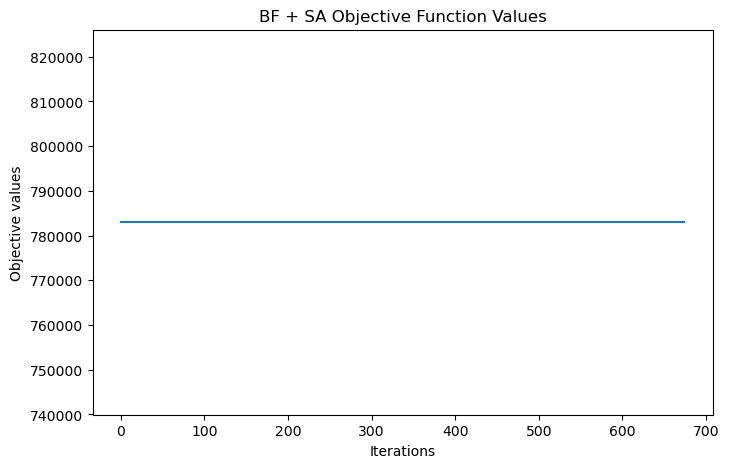

In [12]:
# BF + SA objective value plot 
plt.figure(figsize=(8,5))
plt.title("BF + SA Objective Function Values")
plt.plot(bf_sa_objective_function_results, label="Objective function")
plt.xlabel('Iterations')
plt.ylabel('Objective values')
plt.show()

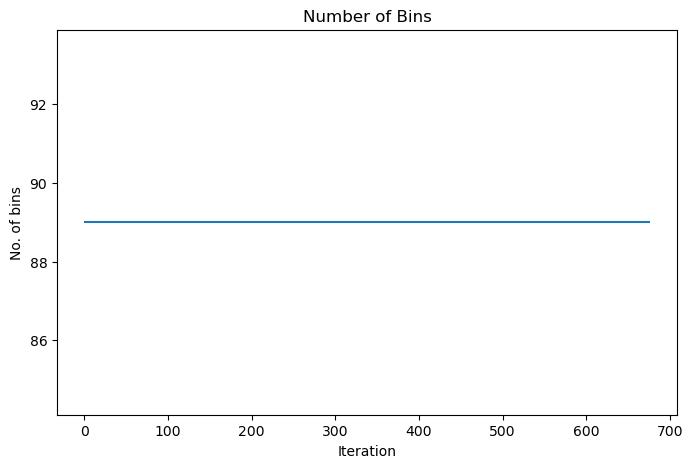

In [13]:
# No. of bins
plt.figure(figsize=(8,5))
plt.title("Number of Bins")
plt.plot(range(1, len(bf_sa_no_of_bins) + 1), bf_sa_no_of_bins, label='Bins Count')
plt.xlabel('Iteration')
plt.ylabel('No. of bins')
plt.show() 

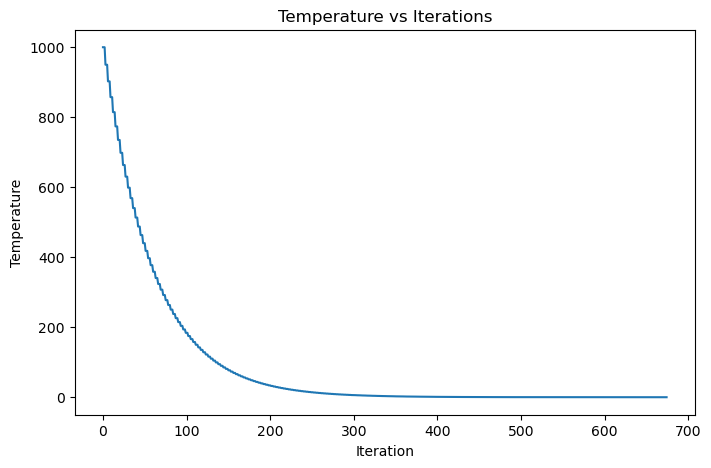

In [14]:
# Temperature
plt.figure(figsize=(8,5))
plt.title("Temperature vs Iterations")
plt.plot(bf_sa_temperatures, label="Temperature")
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.show() 

### Simulated Annealing with First Fit Decreasing

In [15]:
# Initial Variables
bin_capacity = 100
temperature = 1000
cooling_rate = 0.95
stopping_temperature = 0.01
max_iterations = 100000
items = read_csv_file("items.csv")

# Plot values
ffd_sa_objective_function_results = [] 
ffd_sa_no_of_bins = []
ffd_sa_temperatures = [] 

# FFD - First Fit Decreasing
def ffd_function(solution, bin_capacity):
    # sort in the decreasing order
    sorted_solution = sorted(solution, reverse=True) 
    bins = [[]] # empty array to store new solution
    
    for item in sorted_solution:
        placed_in_bin = False # True, if stored in a bin
        for bin_index, bin_items in enumerate(bins):
            # calculate the current sum of the bin
            bin_weight = sum(bin_items)
            # check if bin weight + item doesn't exceed given capacity
            if bin_weight + item <= bin_capacity:
                # append item to whatever the first bin that have space
                bin_items.append(item)
                placed_in_bin = True # confirm item is placed in bin
                break
                
        # start a new bin if no suitable bin found
        if not placed_in_bin:
            bins.append([item])

    return bins

# Simulated annealing
def simulated_annealing_function(items, bin_capacity, temperature, cooling_rate, stopping_temperature, max_iterations):  
    current_solution = ffd_function(items, bin_capacity) # calculate the initial solution
    current_evaluation = objective_function(current_solution) # calculate the initial energy

    # assign current solution and evaluation as the best solution and evaluation
    best_solution = current_solution
    best_evaluation = current_evaluation
    
    for i in range(max_iterations):
        while temperature > stopping_temperature: 
            
            swapping = [swap_one_to_zero_function, swap_zero_to_one_function, swap_one_to_one_function]
            
            for swap in swapping:
                new_candidate = swap(current_solution, bin_capacity) # generate neighbour/new candidates
                new_evaluation = objective_function(new_candidate) # calculate new candidates energy
    
                # compare new and best evaluation
                if new_evaluation > best_evaluation:
                    best_solution, best_evaluation = new_candidate, new_evaluation
    
                energy_variance = new_evaluation - current_evaluation # energy difference
                metropolis = np.exp(-energy_variance / temperature) # calculate metropolis
    
                # acceptance criteria
                if energy_variance < 0 or random.uniform(0, 1) < metropolis:
                    current_solution, current_evaluation = new_candidate, new_evaluation 
    
                # add values to plot
                ffd_sa_objective_function_results.append(best_evaluation)
                ffd_sa_no_of_bins.append(len(current_solution))
                ffd_sa_temperatures.append(temperature)

            # temperature cool down
            temperature *= cooling_rate

    return best_solution, len(best_solution)

In [16]:
# Call the function
first_fit_solution, ffd_minimum_bins = simulated_annealing_function(items, 
                                                                    bin_capacity, 
                                                                    temperature, 
                                                                    cooling_rate, 
                                                                    stopping_temperature, 
                                                                    max_iterations)

# Write items to the file
ffd_path = "first_fit_decreasing_simulated_annealing.txt"
write_to_file_function(ffd_path, ffd_minimum_bins, first_fit_solution)

# Print minimum number to console
print("Number of Bins Used:", ffd_minimum_bins)

Results written to first_fit_decreasing_simulated_annealing.txt
Number of Bins Used: 94


#### Visualisations

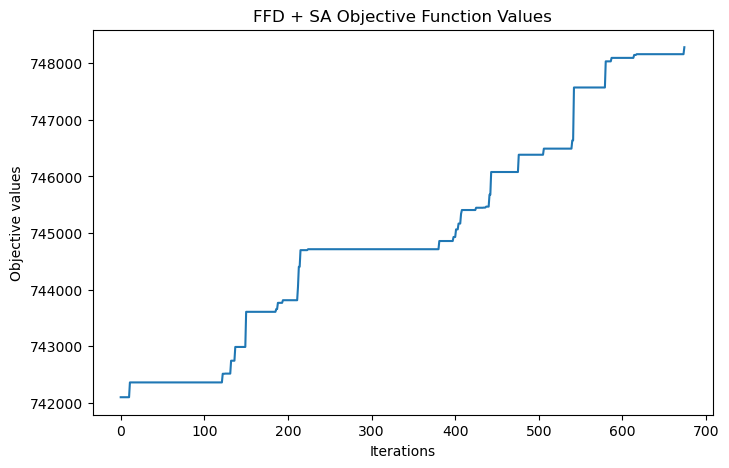

In [17]:
# FFD + SA objective value plot 
plt.figure(figsize=(8,5))
plt.title("FFD + SA Objective Function Values")
plt.plot(ffd_sa_objective_function_results, label="Objective function")
plt.xlabel('Iterations')
plt.ylabel('Objective values') 
plt.show()

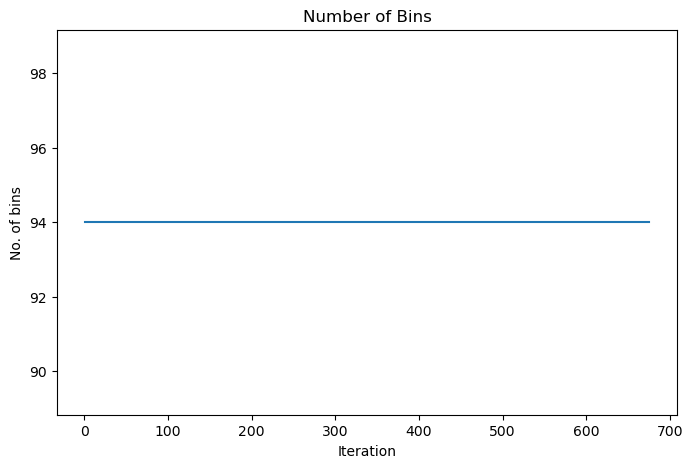

In [18]:
# No. of bins
plt.figure(figsize=(8,5))
plt.title("Number of Bins")
plt.plot(range(1, len(ffd_sa_no_of_bins) + 1), ffd_sa_no_of_bins, label='Bins Count')
plt.xlabel('Iteration')
plt.ylabel('No. of bins')
plt.show() 

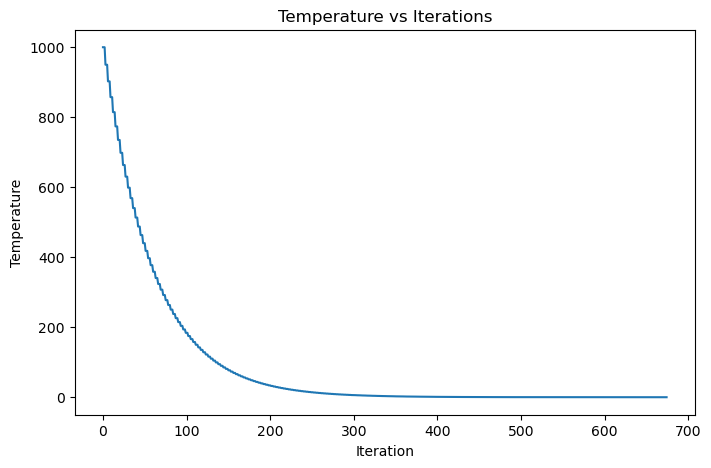

In [19]:
# Temperature
plt.figure(figsize=(8,5))
plt.title("Temperature vs Iterations")
plt.plot(ffd_sa_temperatures, label="Temperature")
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.show() 